# Homework 3

In this homework you will:
* Implement the Naive Bayes algorithm and use it for classification
* Use feature weights learned with logistic regression to assess feature importance

## Naive Bayes

Recall that the Naive Bayes classifier computes $p(\textrm{class} = y|x)$ for an instance where $x = (x_1 = v_1, x_2 = v_2, \ldots, x_n = v_n)$ is a vector of feature values.  It does that for every possible value of the class label and chooses the label that yields the largest probability.  Concretely, that probability is computed as follows (note the use of the "proportional to" symbol $\propto$ below) because we are ignoring the $p(x)$ term that arised from Bayes rule).

$p(class = y|x) \propto p(x_1 = v_1 | class = y) * 
p(x_2 = v_2 | class = y) *
\ldots p(x_n = v_n | class = y) * p(class = y)$

Below you will implement the Naive Bayes classifier (with lots of supporting routines already provided) and apply it to a dataset of mushrooms where the class label is 'p' for poisonous and 'e' for edible.

In [16]:
import pandas as pd

### Load the data

In [17]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [18]:
# Names of features
FEAT_NAMES = df.columns.to_list()[1:]
FEAT_NAMES

['cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [19]:
# Values for the class labels
LABELS = ['p', 'e']
LABELS

['p', 'e']

### Counting

The routine below does counting for you.  Given a dataframe with mushroom instances, it can return 3 kinds of counts:
* Counts of rows with a given class label
* Counts of rows with a given feature value
* Counts of rows with a given class label and a given feature value

You can use this routine when computing the probabilities used by NB.

Read through the code below, and then look at the cells after it to see examples of how to get each of the count types listed above.

NOTE: I using memoization to store counts so they don't have to be computed from the raw data if that are requested a second time.  That's irrelevant to what you need to do.  It's just a simple way to avoid repeated work and will make your code significantly faster.

In [20]:
MEMO = {}

def count_rows(df, y = None, feat_name = None, feat_value = None):
    
    assert y is not None or feat_name is not None, "You must specify at least a class or feature"
    assert (feat_name is None and feat_value is None) or (feat_name is not None and feat_value is not None), "Feature names require feature values, and vice versa"
    
    key = None
    
    if y is not None and feat_name is None:
        key = 'class=%s' % y
        if not key in MEMO:
            MEMO[key] = len(df[df['class'] == y])
    
    if y is not None and feat_name is not None:
        key = 'class=%s;%s=%s' % (y, feat_name, feat_value)
        if not key in MEMO:
            MEMO[key] = len(df[(df['class'] == y) & (df[feat_name] == feat_value)])

    if y is None and feat_name is not None:
        key = '%s=%s' % (feat_name, feat_value)
        if not key in MEMO:
            MEMO[key] = len(df[df[feat_name] == feat_value])

    if key:
        return MEMO[key]
    
    assert True, "Unexpected error"
    

In [21]:
# Count the number of rows with class label 'p'
count_rows(df, y = 'p')

3916

In [22]:
# Count the number of rows for which the cap-surface feature has the value 's'
count_rows(df, feat_name = 'cap-surface', feat_value = 's')

2556

In [23]:
# Count the number of rows for which the class label is 'p' and 
# the cap-surface feature has the value 's'
count_rows(df, y = 'p', feat_name = 'cap-surface', feat_value = 's')

1412

In [24]:
# Compute p(cap-surface = 's' | class = 'p')
print('%.2f' % (count_rows(df, y = 'p', feat_name = 'cap-surface', feat_value = 's')/count_rows(df, y = 'p')))

0.36


### Split the data into training and testing sets

In [25]:
df_train = df[:-1000]
df_test = df[-1000:]

### How to access features and the class label

The code below shows how to get the feature names/values for a test instance as well as the true class label.

The syntax <pre>df_test.iloc[idx]</pre> returns the row in the test dataframe at position idx.  Valid positions run from 0 to len(df_test) - 1.

In [26]:
idx = 10
print('Test instance %d has class = %s\n' % (idx, df_test.iloc[idx]['class']))
for feat_name in FEAT_NAMES:
    feat_value = df_test.iloc[idx][feat_name]
    print('Test instance %d has %s = %s' % (idx, feat_name, feat_value))

Test instance 10 has class = e

Test instance 10 has cap-shape = k
Test instance 10 has cap-surface = s
Test instance 10 has cap-color = g
Test instance 10 has bruises = f
Test instance 10 has odor = n
Test instance 10 has gill-attachment = f
Test instance 10 has gill-spacing = w
Test instance 10 has gill-size = b
Test instance 10 has gill-color = p
Test instance 10 has stalk-shape = e
Test instance 10 has stalk-root = ?
Test instance 10 has stalk-surface-above-ring = k
Test instance 10 has stalk-surface-below-ring = k
Test instance 10 has stalk-color-above-ring = w
Test instance 10 has stalk-color-below-ring = w
Test instance 10 has veil-type = p
Test instance 10 has veil-color = w
Test instance 10 has ring-number = t
Test instance 10 has ring-type = p
Test instance 10 has spore-print-color = w
Test instance 10 has population = s
Test instance 10 has habitat = g


# Task 1 - Implement Naive Bayes

Fill in the function below.  It takes as input the training set and an instance from the test set (e.g., df_test.iloc[10]) and returns the probabilities of the two classes.  I store them in dictionaries, as you can see at the top of my partial implementation.  But you can do whatever you want.  Note that I initialize them to 1.  Think about why I did that. Use count_rows() to get the quantities you need to classify the instance.  To make a prediction you will simply choose the probability with the largest value.

To help debug I've given the probabilities (they are normalized to sum to 1) that I got from my routine for a few test instances.

In [12]:
def NB_probs(df_train, instance):
    probs = {'p':1, 'e':1}
    
    # YOUR CODE GOES HERE
    
    return probs

In [13]:
# Sample output
print(NB_probs(df_train, df_test.iloc[10]))
print(NB_probs(df_train, df_test.iloc[100]))
print(NB_probs(df_train, df_test.iloc[502]))

{'p': 0.6102078440663387, 'e': 0.38979215593366134}
{'p': 1.0, 'e': 0.0}
{'p': 0.37969627358365715, 'e': 0.6203037264163429}


# Task 2 - Use NB_probs() to classify 

Write code in the cell below to walk over the test data and classify each instance.  **Print the classification accuracy at the end.  Also print the index of each instance that is misclassified.**  There is a little skeleton code to get you started.

In [27]:
num_correct = 0
for idx in range(len(df_test)):
    pass
print(num_correct/len(df_test))

0.0


## Logistic Regression

Recall that logistic regression learns a weight vector such that $wx >> 0$ for positive instances and $wx << 0$ for negative instances.  Below you'll look at the weights that were learned and think about which features are important.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

### Load the data

The wine dataset has 13 features that are real valued and **all positive**.  That last bit is important for what follows.  The goal is to classify a sample of wine characterized by its 13 featues into one of three types of wines.

In [29]:
data = load_wine()
X = data['data']
y = data['target']

### Train a classifier and look at the feature weights

The plot below shows the weights associated with all 13 features for each of the three classes.  The are overlaid so that you can compare weights across classes.

/Users/oates/tmp/env/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


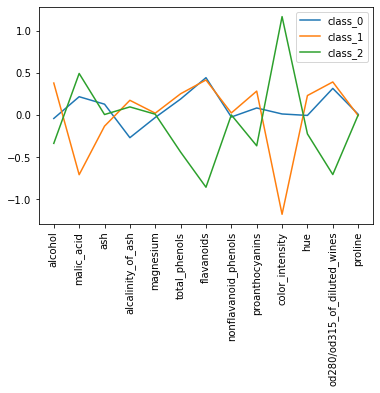

In [30]:
clf = LogisticRegression(C = 1)
clf.fit(X, y)
x = list(range(13))
plt.plot(x, clf.coef_[0], label=data['target_names'][0])
plt.plot(x, clf.coef_[1], label=data['target_names'][1])
plt.plot(x, clf.coef_[2], label=data['target_names'][2])
plt.legend()
plt.xticks(x, data['feature_names'], rotation ='vertical')
plt.show()

# Task 3 - Answer the following questions

Given the plot above, give a brief answer (a few sentences to a paragraph) to each of the following questions.

* Which feature is most important for determining if a sample is class 1?
* Which feature is most important for determining if a sample is class 2?
* If malic_acid is a large number, does that make it more or less likely that the instance belongs to class 1?  Why?
* Which two classes are probably the hardest to tell apart?  Why?
* If you could only keep two features, which ones would you keep to maximize classification accuracy?  Why those two?